<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Neural Networks Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
import os
from skimage.io import imread, imshow
from tqdm import tqdm
import numpy as np
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot


## The Idea of Clipping

In [ ]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)


## Critic Model (Discriminator Model)

In [ ]:
def define_discriminator(in_shape=(32,32,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 16*16
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8*8
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss,metrics=['accuracy'], optimizer=opt)
	return model

## Generator Model

In [ ]:
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16*16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32*32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 32*32*1
	model.add(Conv2D(1, (8,8), activation='tanh', padding='same', kernel_initializer=init))
	return model

# Combining Generator and Critic model

In [ ]:
def define_gan(generator, discriminator):
	# make weights in the critic not trainable
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(discriminator)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss,metrics=['accuracy'], optimizer=opt)
	return model

## load images


In [ ]:
def load_real_samples():

  IMG_WIDTH = 32
  IMG_HEIGHT = 32

  FRAME_PATH_1 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 1/'
  FRAME_PATH_2 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 2/'
  FRAME_PATH_3 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 3/'
  FRAME_PATH_4 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 4/'
  FRAME_PATH_5 = '/content/drive/MyDrive/Dataset_HW6_Q2/Class 5/'


  frame_ids_1 = next(os.walk(FRAME_PATH_1))[2]
  X_1 = np.zeros((len(frame_ids_1), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_1), total=len(frame_ids_1)):
      f_path = FRAME_PATH_1 + id
      img = imread(f_path)[:,:]
      X_1[n] = img
  X_1=expand_dims(X_1, axis=-1).astype('float32')
  X_1= (X_1 - 127.5)  / 127.5


  frame_ids_2 = next(os.walk(FRAME_PATH_2))[2]
  X_2 = np.zeros((len(frame_ids_2), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_2), total=len(frame_ids_2)):
      f_path = FRAME_PATH_2 + id
      img = imread(f_path)[:,:]
      X_2[n] = img
  X_2=expand_dims(X_2, axis=-1).astype('float32')
  X_2= (X_2 - 127.5)  / 127.5


  frame_ids_3 = next(os.walk(FRAME_PATH_3))[2]
  X_3 = np.zeros((len(frame_ids_3), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_3), total=len(frame_ids_3)):
      f_path = FRAME_PATH_3 + id
      img = imread(f_path)[:,:]
      X_3[n] = img
  X_3=expand_dims(X_3, axis=-1).astype('float32')
  X_3= (X_3 - 127.5)  / 127.5


  frame_ids_4 = next(os.walk(FRAME_PATH_4))[2]
  X_4 = np.zeros((len(frame_ids_4), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_4), total=len(frame_ids_4)):
      f_path = FRAME_PATH_4 + id
      img = imread(f_path)[:,:]
      X_4[n] = img
  X_4=expand_dims(X_4, axis=-1).astype('float32')
  X_4= (X_4 - 127.5)  / 127.5



  frame_ids_5 = next(os.walk(FRAME_PATH_5))[2]
  X_5 = np.zeros((len(frame_ids_5), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
  for n, id in tqdm(enumerate(frame_ids_5), total=len(frame_ids_5)):
      f_path = FRAME_PATH_5 + id
      img = imread(f_path)[:,:]
      X_5[n] = img
  X_5=expand_dims(X_5, axis=-1).astype('float32')
  X_5= (X_5 - 127.5)  / 127.5

  X=np.concatenate((X_1,X_2,X_3,X_4,X_5),axis=0)
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
import matplotlib.pyplot as plt
def plot_history(d1_hist, d2_hist, g_hist):
  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(5)
  plt.subplot(1,2,1)
  plt.plot(d1_hist[:,0])
  plt.plot(d2_hist[:,0])
  plt.plot(g_hist[:,0])
  plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
  plt.title('Loss')
  plt.subplot(1,2,2)
  plt.plot(d1_hist[:,1])
  plt.plot(d2_hist[:,1])
  plt.plot(g_hist[:,1])
  plt.legend(['Discriminator on real images','Discriminator on fake images','Generator'])
  plt.title('Accuracy')

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=64, n_discriminator=5):
    bat_per_epo= int(dataset.shape[0] / n_batch)

    # calculate the number of training iterations
    n_steps= bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist= np.zeros((n_steps,2)),np.zeros((n_steps,2)),np.zeros((n_steps,2))
    # manually enumerate epochs
    for i in range(n_steps):

        # update the critic more than the generator
        d1_tmp, d2_tmp = np.zeros((n_discriminator,2)),np.zeros((n_discriminator,2))
        for k in range(n_discriminator):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            d_loss1 = d_model.train_on_batch(X_real, y_real,reset_metrics=False ,return_dict = False)
            d1_tmp[k]=d_loss1
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            d_loss2 = d_model.train_on_batch(X_fake, y_fake,reset_metrics=False ,return_dict = False)
            d2_tmp[k]=d_loss2
        # store critic loss
        d1_hist[i]=mean(d1_tmp,axis=0)
        d2_hist[i]=mean(d2_tmp,axis=0)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan,reset_metrics=False ,return_dict = False)
        g_hist[i]=g_loss
        # summarize loss on this batch
        #print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, d1_hist[-1], d2_hist[-1], g_loss))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo*20) == 0:
          summarize_performance(i, g_model, latent_dim)


      # line plots of loss
    plot_history(d1_hist, d2_hist, g_hist)
    #return d1_tmp,d2_tmp,d1_hist,d2_hist,g_hist


100%|██████████| 201/201 [00:00<00:00, 582.49it/s]


(1005, 32, 32, 1)
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_0300.png and model_0300.h5
4/4 [==============================] - 0s 7ms/step


>Saved: generated_plot_0600.png and model_0600.h5
4/4 [==============================] - 0s 10ms/step


>Saved: generated_plot_0900.png and model_0900.h5
4/4 [==============================] - 0s 8ms/step


>Saved: generated_plot_1200.png and model_1200.h5
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_1500.png and model_1500.h5
4/4 [==============================] - 0s 8ms/step


>Saved: generated_plot_1800.png and model_1800.h5
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_2100.png and model_2100.h5
4/4 [==============================] - 0s 9ms/step


>Saved: generated_plot_2400.png and model_2400.h5
4/4 [==============================] - 0s 7ms/step


>Saved: generated_plot_2700.png and model_2700.h5
4/4 [==============================] - 0s 8ms/step


>Saved: generated_plot_3000.png and model_3000.h5


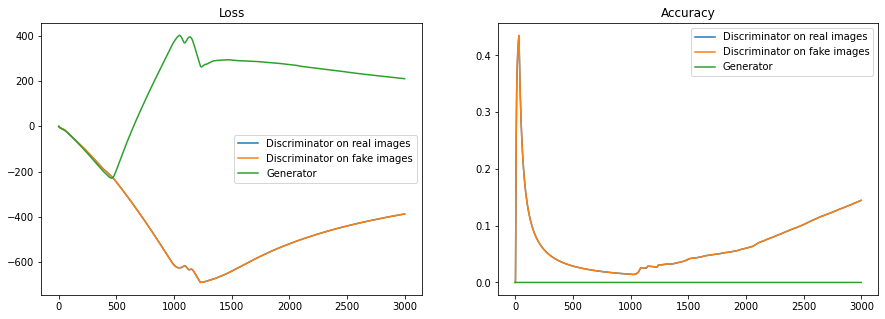

In [ ]:
# size of the latent space
latent_dim = 100
# create the critic
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

## loading the generator model and generating images

1/1 [==============================] - 0s 88ms/step


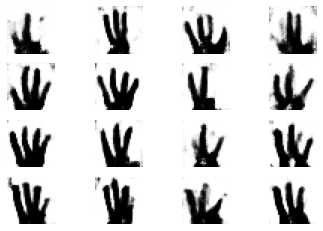

In [ ]:
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='binary')
	pyplot.show()

# load model
model = load_model('model_3000.h5')
latent_dim = 100
n_examples = 16 # must be a square
# generate images
latent_points = generate_latent_points(latent_dim, n_examples)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)